# Lab 3: Policy Search

Write agents able to play Nim, with an arbitrary number of rows and an upper bound on the number of objects that can be removed in a turn (a.k.a., subtraction game).

- Task3.1: An agent using fixed rules based on nim-sum (i.e., an expert system)
- Task3.2: An agent using evolved rules
- Task3.3: An agent using minmax
- Task3.4: An agent using reinforcement learning

In [1]:
import logging
from collections import namedtuple
import random
from copy import deepcopy
from itertools import accumulate
from operator import xor
import math

In [2]:
logging.basicConfig(format="%(message)s", level=logging.INFO)

### The Nim and Nimply classes

In [3]:
Nimply = namedtuple("Nimply", "row, num_objects")

In [4]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k
        self._turn = 0
        # 0 indicates that player 1 should move
        # 1 indicates that player 2 should move

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    @property
    def k(self) -> int:
        return self._k

    @property
    def turn(self) -> int:
        return self._turn

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects
        self._turn = 1 - self._turn

In [5]:
def possible_moves(nim: Nim):
    return [Nimply(r, o) for r, c in enumerate(nim.rows) for o in range(1, c + 1) if nim.k is None or o <= nim.k]

## An agent using fixed rules

### The random strategy

The hardcoded agent can use a set of fixed strategies: the first one consists in removing a random number of sticks from a random row, if the row has one or more sticks.

In [6]:
def random_strategy(nim: Nim, num_law=None, nimming=True):
    moves_list = possible_moves(nim)

    if len(moves_list) > 0:
        move = random.choice(moves_list)
        if nimming:
            nim.nimming(move)
        return move
    else:
        logging.info("No more moves allowed!")

### The nim sum

The following description was taken from [here](https://dmf.unicatt.it/~paolini/divulgazione/mateappl/nim/nim.html).

In a game of nim that involves nim heaps where you can take as many objects as you want from any one of the heaps during your turn, you need to be able to compute a nim sum, that characterizes the configuration of the game.

Here's how to do it:

- Express the number of objects in each nim heap as a binary number, with the only digits being 0 and 1.
- Fill out the smaller binary numbers with '0's on the left, if necessary, so that all the numbers have the same number of digits.
- Sum the binary numbers, but do not carry.
- Replace each digit in the sum with the remainder that results when the digit is divided by 2.
- This yields the nim sum.
- To win at nim, always make a move, when possible, that leaves a configuration with a nim sum of 0. If you cannot do this, your opponent has the advantage, and you have to depend on his or her committing an error in order to win.
    - Note that if the configuration you are given has a nim sum not equal to 0, there always is a move that creates a new configuration with a nim sum of 0. However, there are usually also moves that will yield configurations that give nim sums not equal to 0, and you need to avoid making these.
    - Also note that if you are given a configuration that has a nim sum of 0, there is no move that will create a configuration that also has a nim sum of 0.

In this implementation, the nim sum is calculated as the bitwise xor of the rows.

In [7]:
def nim_sum(state: Nim) -> int:
    *_, result = accumulate(state.rows, xor)
    return result

### The nim sum strategy

The second strategy consists in calculating the nim sum of the current board:
- if it is not zero, evaluate some random moves until a zero nim sum is found.
- if it is zero, perform a random move.

In [8]:
def nim_sum_strategy(nim: Nim, num_law=None, nimming=True):
    if nim_sum(nim) != 0:
        moves_list = possible_moves(nim)
        for move in moves_list:
            temp_nim = deepcopy(nim)
            temp_nim.nimming(move)
            if nim_sum(temp_nim) == 0:
                if nimming:
                    nim.nimming(move)
                return move
    random_strategy(nim)

### The not so smart strategy

This strategy emulates an human (that can make errors), and consists in using the nim sum strategy with a 70% probability (by default) or the random strategy otherwise.

In [9]:
def not_so_smart_strategy(nim: Nim, num_law=None, smartness=0.7, nimming=True):
    if random.random() < smartness:
        return nim_sum_strategy(nim, nimming=nimming)
    else:
        return random_strategy(nim, nimming=nimming)

## The match

The play_nim function takes some parameters:
- `n` indicates the number of rows on the board.
- `first_strategy` indicates the method used by the first agent to make a move.
- `second_strategy` indicates the method used by the second agent to make a move.
- `who_starts` indicates who makes the first move; it is an even number (tipically 0) to indicate the first agent and an odd number (tipically 1) to indicate the second agent.
- `first_num_law` and `second_num_law` are two special parameters that will be used for the evolved rules.

The first agent will always move first.

In [10]:
def play_nim(n, first_strategy, second_strategy, who_starts, first_num_law=0, second_num_law=0):
    nim = Nim(n)
    #logging.info(f"Initial setting: {nim.rows} - Nim sum: {nim_sum(nim)}")
    nim._turn = who_starts % 2
    while nim:
        if nim.turn == 0: # first agent's turn
            first_strategy(nim, num_law=first_num_law)
            #logging.info(f"First agent's turn: {nim.rows} - Nim sum: {nim_sum(nim)}")
        else: # second agent's turn
            second_strategy(nim, num_law=second_num_law)
            #logging.info(f"Second agent's turn: {nim.rows} - Nim sum: {nim_sum(nim)}")
    return (1 - nim.turn)


In [11]:
def single_game(n, first_strategy, second_strategy, who_starts, first_num_law=0, second_num_law=0):
    winner = play_nim(n, first_strategy, second_strategy, who_starts, first_num_law, second_num_law)
    if winner == 0:
        logging.info("--- The first agent won! ---\n")
    else:
        logging.info("--- The second agent won! ---\n")

### First version: second agent's random strategy

In [12]:
logging.info("Game 1:\n N = 5\n Start: First Agent\n First agent: nim sum strategy\n Second agent: random strategy")
single_game(5, nim_sum_strategy, random_strategy, 0)

logging.info("Game 2:\n N = 5\n Start: Second Agent\n First agent: nim sum strategy\n Second agent: random strategy")
single_game(5, nim_sum_strategy, random_strategy, 1)

Game 1:
 N = 5
 Start: First Agent
 First agent: nim sum strategy
 Second agent: random strategy
--- The first agent won! ---

Game 2:
 N = 5
 Start: Second Agent
 First agent: nim sum strategy
 Second agent: random strategy
--- The first agent won! ---



### Second version: Everyone is using the nim sum strategy

In [13]:
logging.info("Game 3:\n N = 5\n Start: First Agent\n First agent: nim sum strategy \n Second agent: nim sum strategy")
single_game(5, nim_sum_strategy, nim_sum_strategy, 0)

logging.info("Game 4:\n N = 5\n Start: Second Agent\n First agent: nim sum strategy\n Second agent: nim sum strategy")
single_game(5, nim_sum_strategy, nim_sum_strategy, 1)

Game 3:
 N = 5
 Start: First Agent
 First agent: nim sum strategy 
 Second agent: nim sum strategy
--- The first agent won! ---

Game 4:
 N = 5
 Start: Second Agent
 First agent: nim sum strategy
 Second agent: nim sum strategy
--- The second agent won! ---



### Third version: The agent is using the not so smart strategy

This strategy emulates an human (that can make errors), and consists in using the nim sum strategy with a 70% probability or the random strategy otherwise.

In [14]:
logging.info("Game 5:\n N = 5\n Start: First Agent\n First agent: nim sum strategy\n Second agent: not so smart strategy")
single_game(5, nim_sum_strategy, not_so_smart_strategy, 0)

logging.info("Game 6:\n N = 5\n Start: Second Agent\n First agent: nim sum strategy\n Second agent: not so smart strategy")
single_game(5, nim_sum_strategy, not_so_smart_strategy, 1)

Game 5:
 N = 5
 Start: First Agent
 First agent: nim sum strategy
 Second agent: not so smart strategy
--- The first agent won! ---

Game 6:
 N = 5
 Start: Second Agent
 First agent: nim sum strategy
 Second agent: not so smart strategy
--- The first agent won! ---



## An agent using evolved rules

### The new strategies

New strategies have been defined; they are based on feasible human moves and each of them can be executed with five variations, by removing either one, half, one-third, two-third or all the items in the chosen row.

The strategies are:
- shortest row
- longest row
- first row
- last row
- middle row

In [15]:
def items_to_remove(num_law, num):
    assert num > 0
    if num_law == 0: # all the item
        return num
    elif num_law == 1: # one item
        return 1
    elif num_law == 2: # half of the items
        return int((num+1)/2)
    elif num_law == 3: # one-third of the items
        return int((num+2)/3)
    else: # two-third of the items
        return int((num+1)/3) + 1

def shortest_row_strategy(nim: Nim, num_law=0, nimming=True):
    move = min((x for x in enumerate(nim.rows) if x[1] > 0), key=lambda y: y[1])
    move = Nimply(move[0], items_to_remove(num_law, move[1]))
    if nimming:
        nim.nimming(move)
    return move


def longest_row_strategy(nim: Nim, num_law=0, nimming=True):
    move = max((x for x in enumerate(nim.rows)), key=lambda y: y[1])
    move = Nimply(move[0], items_to_remove(num_law, move[1]))
    if nimming:
        nim.nimming(move)
    return move


def first_row_strategy(nim: Nim, num_law=0, nimming=True):
    move = min((x for x in enumerate(nim.rows) if x[1] > 0), key=lambda y: y[0])
    move = Nimply(move[0], items_to_remove(num_law, move[1]))
    if nimming:
        nim.nimming(move)
    return move

def last_row_strategy(nim: Nim, num_law=0, nimming=True):
    move = max((x for x in enumerate(nim.rows) if x[1] > 0), key=lambda y: y[0])
    move = Nimply(move[0], items_to_remove(num_law, move[1]))
    if nimming:
        nim.nimming(move)
    return move


def middle_row_strategy(nim: Nim, num_law=0, nimming=True):
    _list = list(x for x in enumerate(nim.rows) if x[1 > 0])
    move = _list[int(len(_list) / 2)]
    move = Nimply(move[0], items_to_remove(num_law, move[1]))
    if nimming:
        nim.nimming(move)
    return move
    

### The population and the individual
The population is formed by all the possible rules, an individual is a single rule with a certain "num_law".

In [16]:
population = [shortest_row_strategy, longest_row_strategy, first_row_strategy, last_row_strategy, middle_row_strategy]
num_laws = [0, 1, 2, 3, 4]

### Fitness
The fitness is obtained by calculated the winning ratio of that individual.

In [17]:
def fitness(won, total_matches):
    return won/total_matches

### The rule-finding phase

During the rule-finding phase, each strategy (with their variation) is used in a fixed number of matches against the random strategy. Each match is repeated twice, alternating the starting strategy.

At the end, all the winning ratios are compared and a winner is decreed.

In [18]:
NUM_MATCHES = 1000
NUM_SIZE = 10

evaluations = dict()

for index, individual in enumerate(population):
    for law in num_laws:
        won = 0
        for match in range(NUM_MATCHES):
            winner = play_nim(NUM_SIZE, individual, random_strategy, match % 2, first_num_law=law)
            won += (1 - winner)
        fit = fitness(won, NUM_MATCHES)
        evaluations[f"{population[index].__name__}, law {law}"] = [index, law, fit]
        #logging.info(f"{population[index].__name__}, law {law} - Fitness: {fit}")

best = max((x for x in evaluations), key=lambda y: evaluations[y][2])
evolved_strategy = population[evaluations[best][0]]
evolved_strategy_law = evaluations[best][1]
logging.info(f"Best strategy: {best} - Fitness: {evaluations[best][2]}")

Best strategy: shortest_row_strategy, law 0 - Fitness: 0.912


### Evaluation phase

The winning strategy is evaluated again: new matches are played all the other strategies. At the end the winning ratio is calculated; if it is high enough, then the strategy is the best possible (so far).

In [19]:
won = 0
for individual in population:
    for law in num_laws:
        for match in range(NUM_MATCHES):
            winner = play_nim(
                NUM_SIZE,
                evolved_strategy,
                individual,
                match % 2,
                first_num_law=evolved_strategy_law,
                second_num_law=law
            )
            won += (1 - winner)


logging.info(f"{best} - Fitness: {fitness(won, len(population)*len(num_laws)*NUM_MATCHES)}")

shortest_row_strategy, law 0 - Fitness: 0.9


## An agent using minmax

I am maximizing my possible reward.<br>
My opponent is minimizing my possible reward (so maximizing his reward).

When it's my turn:
- Calculate all the possible moves.
- Calculate all the possible moved for my opponent (for each of my moves)
- Keep on calculating, until all the possible combinations end in someone winning.
- Alpha beta pruning was included in the implementation.
- Pick the path that maximize my reward.

In [20]:
def minmax(nim: Nim, alpha = -1, beta = 1, player = 1, depth = 0):
    if depth > 10:
        return None, -player
    if not nim:
        #print(f"End at depth {depth} - Player {0 if player == 1 else 1}")
        return None, player
    evaluations = list()
    for ply in possible_moves(nim):
        #print(f"Player {0 if player == 1 else 1} - Move {depth}: {ply}")
        board = deepcopy(nim)
        board.nimming(ply)
        _, val = minmax(board, alpha=alpha, beta=beta, player=-player, depth=depth+1)
        evaluations.append((ply, val))
        if player == 1:
            beta = min(beta, val)
        else:
            alpha = max(alpha, val)
        if beta <= alpha:
            break
    if player == 1:
        return min(evaluations, key=lambda k: k[1])
    else:
        return max(evaluations, key=lambda k: k[1])

In [21]:
def minmax_strategy(nim: Nim, num_law=None, nimming=True):
    best_ply, _ = minmax(nim)
    if nimming:
        nim.nimming(best_ply)
    return best_ply

### Match against random strategy

In [22]:
NUM_MATCHES = 100
NUM_ROWS = 3

won = 0
for match in range(NUM_MATCHES):
    won += (1 - play_nim(NUM_ROWS, minmax_strategy, random_strategy, match % 2))
logging.info(f"N = {NUM_ROWS} - Win ratio: {won/(NUM_MATCHES)}")

N = 3 - Win ratio: 1.0


In [23]:
NUM_MATCHES = 10
NUM_ROWS = 4

won = 0
for match in range(NUM_MATCHES):
    won += (1 - play_nim(NUM_ROWS, minmax_strategy, random_strategy, match % 2))
logging.info(f"Win ratio: {won/(NUM_MATCHES)}")

Win ratio: 1.0


### Match against evolved strategy

In [24]:
NUM_MATCHES = 100
NUM_ROWS = 3

won = 0
for match in range(NUM_MATCHES):
    won += (1 - play_nim(NUM_ROWS, minmax_strategy, evolved_strategy, match % 2, second_num_law=evolved_strategy_law))
logging.info(f"Win ratio: {won/(NUM_MATCHES)}")

Win ratio: 1.0


In [25]:
NUM_MATCHES = 10
NUM_ROWS = 4

won = 0
for match in range(NUM_MATCHES):
    won += (1 - play_nim(NUM_ROWS, minmax_strategy, evolved_strategy, match % 2, second_num_law=evolved_strategy_law))
logging.info(f"Win ratio: {won/(NUM_MATCHES)}")

Win ratio: 1.0


### Match against nim sum strategy
The win ratio should be 1 if the minmax agent starts first, 0 otherwise

In [26]:
NUM_MATCHES = 100
NUM_ROWS = 3

won = 0
for _ in range(NUM_MATCHES):
    won += (1 - play_nim(NUM_ROWS, minmax_strategy, nim_sum_strategy, 0))
logging.info(f"Win ratio: {won/NUM_MATCHES}")

Win ratio: 1.0


In [45]:
NUM_MATCHES = 10
NUM_ROWS = 4

won = 0
for _ in range(NUM_MATCHES):
    won += (1 - play_nim(NUM_ROWS, minmax_strategy, nim_sum_strategy, 0))
logging.info(f"Win ratio: {won/NUM_MATCHES}")

Win ratio: 0.0


In [28]:
NUM_MATCHES = 100
NUM_ROWS = 3

won = 0
for _ in range(NUM_MATCHES):
    won += (1 - play_nim(NUM_ROWS, minmax_strategy, nim_sum_strategy, 1))
logging.info(f"Win ratio: {won/NUM_MATCHES}")

Win ratio: 0.0


In [48]:
NUM_MATCHES = 10
NUM_ROWS = 4

won = 0
for _ in range(NUM_MATCHES):
    won += (1 - play_nim(NUM_ROWS, minmax_strategy, nim_sum_strategy, 1))
logging.info(f"Win ratio: {won/NUM_MATCHES}")

Win ratio: 0.7


## An agent using reinforcement learning

In [30]:
import matplotlib.pyplot as plt
import numpy as np

In [31]:
class Agent(object):
    def __init__(self, states, alpha=0.15, random_factor=0.2):  # 80% explore, 20% exploit
        self.state_history = [(states.rows, 0)]  # state, reward
        self.alpha = alpha
        self.random_factor = random_factor
        self.G = {}

    def choose_action(self, state, allowedMoves):
        maxG = -10e15
        next_move = None
        randomN = np.random.random()
        if randomN < self.random_factor:
            # if random number below random factor, choose random action
            next_move = random.choice(allowedMoves)

            new_state = deepcopy(state)
            new_state.nimming(next_move)
            if new_state.rows not in self.G.keys():
                self.G[new_state.rows] = np.random.uniform(low=1.0, high=0.1)
        else:
            # if exploiting, gather all possible actions and choose one with the highest G (reward)
            for action in allowedMoves:
                new_state = deepcopy(state)
                new_state.nimming(action)

                if new_state.rows not in self.G.keys():
                    self.G[new_state.rows] = np.random.uniform(low=1.0, high=0.1)
                
                if self.G[new_state.rows] >= maxG:
                    next_move = action
                    maxG = self.G[new_state.rows]

        return next_move

    def update_state_history(self, state, reward):
        self.state_history.append((state.rows, reward))

    def learn(self):
        target = 0

        for prev, reward in reversed(self.state_history):
            if prev not in self.G.keys():
                self.G[prev] = np.random.uniform(low=1.0, high=0.1)
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])
            target += reward

        self.state_history = []

        self.random_factor -= 10e-5  # decrease random factor each episode of play


### The reward

The agents gets a 1 reward if the move he does is the winning one (the last move of the game), 0 otherwise.

In [32]:
def get_reward(nim: Nim):
    return 0 if nim else 1

### The learning phase

During the learning phase, the agent is trained against the random strategy. 10000 matches are performed and, at the end, the agent improves significantly.

In [33]:
def train(agent: Agent, opponent_strategy, opponent_law=None):
    NUM_MATCHES = 10000
    NIM_NUM = 5
    nim = Nim(NIM_NUM)
    rateHistory = []
    indices = []
    win_ratio = 0
    for match in range(NUM_MATCHES):
        while nim:
            action = agent.choose_action(nim, possible_moves(nim))
            nim.nimming(action)
            reward = get_reward(nim)
            agent.update_state_history(nim, reward)
            if nim:
                opponent_strategy(nim, opponent_law)
        if nim.turn == 1:
            win_ratio +=1
        agent.learn()
        if match % 100 == 0:
            rateHistory.append(win_ratio / 100)
            indices.append(match)
            win_ratio = 0
        nim = Nim(NIM_NUM)

    plt.semilogy(indices, rateHistory, "b")
    plt.show()

### Reinforcement learning against random strategy

In [34]:
NIM_NUM = 5
nim = Nim(NIM_NUM)
rl_agent = Agent(nim, alpha=0.1, random_factor=0.4)

In [35]:
def rl_strategy(nim: Nim, num_law=None, nimming=True):
    action = rl_agent.choose_action(nim, possible_moves(nim))
    if nimming:
        nim.nimming(action)
    return action

#### The first evaluation

In [36]:
NUM_MATCHES = 100
won = 0
for _ in range(NUM_MATCHES):
    won += (1 - play_nim(NIM_NUM, rl_strategy, random_strategy, 0))
logging.info(f"Win ratio: {won/NUM_MATCHES}")

Win ratio: 0.6


#### The training phase

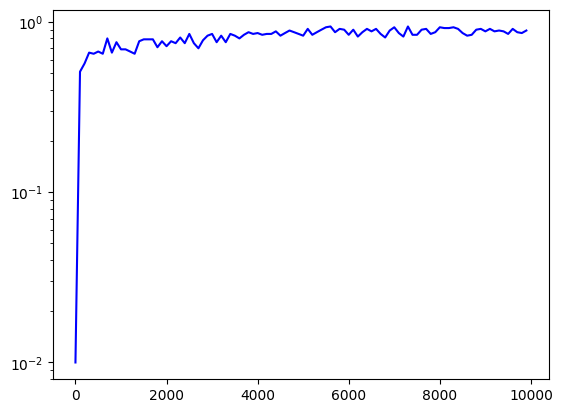

In [37]:
NIM_NUM = 5
nim = Nim(NIM_NUM)
rl_agent = Agent(nim, alpha=0.1, random_factor=0.4)
train(rl_agent, random_strategy, None)

#### The second evaluation

In [38]:
NUM_MATCHES = 100
won = 0
for _ in range(NUM_MATCHES):
    won += (1 - play_nim(NIM_NUM, rl_strategy, random_strategy, 0))
logging.info(f"Win ratio: {won/NUM_MATCHES}")

Win ratio: 0.91


### RL against evolved strategy

#### The first evaluation

In [39]:
NUM_MATCHES = 100
won = 0
for _ in range(NUM_MATCHES):
    won += (1 - play_nim(NIM_NUM, rl_strategy, evolved_strategy, 0, second_num_law=evolved_strategy_law))
logging.info(f"Win ratio: {won/NUM_MATCHES}")

Win ratio: 0.0


#### The learning phase

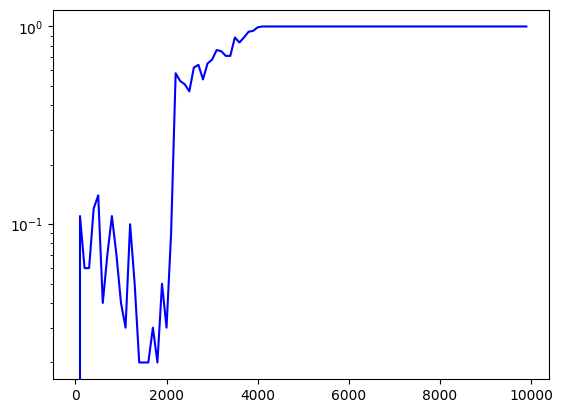

In [40]:
NIM_NUM = 5
nim = Nim(NIM_NUM)
rl_agent = Agent(nim, alpha=0.1, random_factor=0.4)
train(rl_agent, evolved_strategy, opponent_law=evolved_strategy_law)

#### The second evaluation

In [41]:
NUM_MATCHES = 100
won = 0
for _ in range(NUM_MATCHES):
    won += (1 - play_nim(NIM_NUM, rl_strategy, evolved_strategy, 0, second_num_law=evolved_strategy_law))
logging.info(f"Win ratio: {won/NUM_MATCHES}")

Win ratio: 1.0


### RL against nim sum strategy

#### The first evaluation

In [42]:
NUM_MATCHES = 100
won = 0
for _ in range(NUM_MATCHES):
    won += (1 - play_nim(NIM_NUM, rl_strategy, nim_sum_strategy, 0))
logging.info(f"Win ratio: {won/NUM_MATCHES}")

Win ratio: 0.0


#### The learning phase

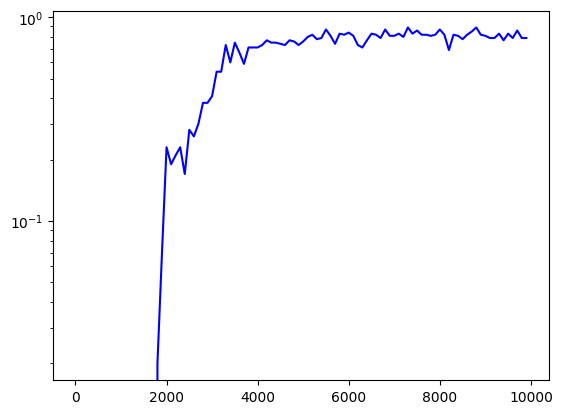

In [43]:
NIM_NUM = 5
nim = Nim(NIM_NUM)
rl_agent = Agent(nim, alpha=0.1, random_factor=0.4)
train(rl_agent, nim_sum_strategy)

#### The second evaluation

In [44]:
NUM_MATCHES = 100
won = 0
for _ in range(NUM_MATCHES):
    won += (1 - play_nim(NIM_NUM, rl_strategy, nim_sum_strategy, 0))
logging.info(f"Win ratio: {won/NUM_MATCHES}")

Win ratio: 0.91
